<a href="https://colab.research.google.com/github/Redwolf0023/AutoMLvsBayesian/blob/main/House_Price_Prediction_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install and download the dependencies
!sudo apt-get install swig -y
!pip install Cython numpy
!pip install scikit-learn
!apt-get install default-jre
!java -version
!pip install h2o

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
swig is already the newest version (4.0.2-1ubuntu1).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
default-jre is already the newest version (2:1.11-72build2).
0 upgraded, 0 newly installed, 0 to remove and 16 not upgraded.
openjdk version "11.0.20" 2023-07-18
OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)


In [ ]:
# import the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h2o
import seaborn as sns
from h2o.automl import H2OAutoML
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score

In [ ]:
# import the input file as a dataset
df = pd.read_csv('Housing.csv')

In [ ]:
df.head()

,price,area,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [ ]:
df.isnull().sum()

price               0
area                0
bedrooms            0
bathrooms           0
stories             0
mainroad            0
guestroom           0
basement            0
hotwaterheating     0
airconditioning     0
parking             0
prefarea            0
furnishingstatus    0
dtype: int64

<ipython-input-10-f11195812e78>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True, cbar = True, cmap = 'Blues')


Text(0.5, 1.0, 'Heat Map')

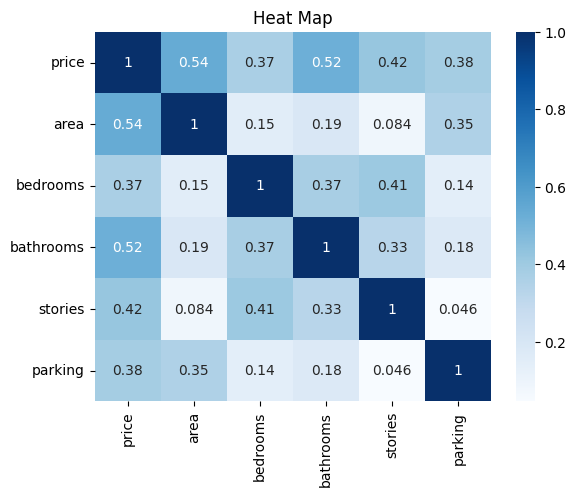

In [ ]:
# check for correlation
sns.heatmap(df.corr(),annot = True, cbar = True, cmap = 'Blues')
plt.title("Heat Map")

In [ ]:
df.drop('stories',axis = 1)

,price,area,bedrooms,bathrooms,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,4,2,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,3,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,4,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,4,1,yes,yes,yes,no,yes,2,no,furnished
...,...,...,...,...,...,...,...,...,...,...,...,...
540,1820000,3000,2,1,yes,no,yes,no,no,2,no,unfurnished
541,1767150,2400,3,1,no,no,no,no,no,0,no,semi-furnished
542,1750000,3620,2,1,yes,no,no,no,no,0,no,unfurnished
543,1750000,2910,3,1,no,no,no,no,no,0,no,furnished


In [ ]:
from sklearn.preprocessing import OneHotEncoder
columns_to_encode = ['mainroad','guestroom','basement','hotwaterheating','airconditioning','furnishingstatus','prefarea']

# Initialize the OneHotEncoder
encoder = OneHotEncoder(drop='first', sparse=False)  # 'drop' parameter removes the first category to avoid multicollinearity

encoded_columns = encoder.fit_transform(df[columns_to_encode])

# Get the feature names after encoding
feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded values and column names
encoded_df = pd.DataFrame(encoded_columns, columns=feature_names)

# Concatenate the original DataFrame with the encoded DataFrame
data_encoded = pd.concat([df, encoded_df], axis=1)


# Display the encoded DataFrame
data_encoded = data_encoded.drop(['mainroad','guestroom','basement','hotwaterheating','airconditioning','furnishingstatus','prefarea'],axis = 1)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
# initialise the cluster
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.20" 2023-07-18; OpenJDK Runtime Environment (build 11.0.20+8-post-Ubuntu-1ubuntu122.04); OpenJDK 64-Bit Server VM (build 11.0.20+8-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.10/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpu8qewn86
  JVM stdout: /tmp/tmpu8qewn86/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpu8qewn86/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,07 secs
H2O_cluster_timezone:,Etc/UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.42.0.3
H2O_cluster_version_age:,3 days
H2O_cluster_name:,H2O_from_python_unknownUser_xr1f82
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.170 Gb
H2O_cluster_total_cores:,2
H2O_cluster_allowed_cores:,2
H2O_cluster_status:,"locked, healthy"


In [ ]:
# parse the dataset
data = h2o.H2OFrame(data_encoded)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
data.head()

price,area,bedrooms,bathrooms,stories,parking,mainroad_yes,guestroom_yes,basement_yes,hotwaterheating_yes,airconditioning_yes,furnishingstatus_semi-furnished,furnishingstatus_unfurnished,prefarea_yes
1.33e+07,7420,4,2,3,2,1,0,0,0,1,0,0,1
1.225e+07,8960,4,4,4,3,1,0,0,0,1,0,0,0
1.225e+07,9960,3,2,2,2,1,0,1,0,0,1,0,1
1.2215e+07,7500,4,2,2,3,1,0,1,0,1,0,0,1
1.141e+07,7420,4,1,2,2,1,1,1,0,1,0,0,0
1.085e+07,7500,3,3,1,2,1,0,1,0,1,1,0,1
1.015e+07,8580,4,3,4,2,1,0,0,0,1,1,0,1
1.015e+07,16200,5,3,2,0,1,0,0,0,0,0,1,0
9.87e+06,8100,4,1,2,2,1,1,1,0,1,0,0,1
9.8e+06,5750,3,2,4,1,1,1,0,0,1,0,1,1


In [ ]:
target_col = data.columns[0]
feature_col = data.columns[0:]
data[target_col] = data[target_col].asfactor()

In [ ]:
target_col

'price'

In [ ]:
train, test, validation = data.split_frame(ratios=[0.8, 0.15], seed = 12)

In [ ]:
# train the H2O model
model = H2OAutoML(max_models=20, seed = 1234)
model.train(x = feature_col, y = target_col, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████ (cancelled)  83%


H2OJobCancelled: ignored

In [ ]:
# Import libraries
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF,ConstantKernel, DotProduct, Matern,ExpSineSquared,WhiteKernel,RationalQuadratic
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, log_loss, r2_score,mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.metrics import roc_auc_score as ras

In [ ]:
df1 = data_encoded.copy()

In [ ]:
x = df1.drop('price', axis=1).values
y = df1['price'].values

In [ ]:
# Standardize the feature columns and encode the target variable
from sklearn import preprocessing
SS = preprocessing.StandardScaler()
LE = preprocessing.LabelEncoder()
x = SS.fit_transform(x)
y = LE.fit_transform(y)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train.shape,x_test.shape,y_train.shape,y_test.shape

((436, 13), (109, 13), (436,), (109,))

In [ ]:

# Initialize the Gaussian Process Regressor using Rational quadratic kernel
kernel = 1.0* RationalQuadratic(length_scale=1.0, alpha=1.0)
gp = GaussianProcessRegressor(kernel=kernel, alpha=5e-9, optimizer='fmin_l_bfgs_b',
                                n_restarts_optimizer=0, normalize_y=False, copy_X_train=True,
                                random_state=20)

# Train the Gaussian Process Regressor
gp.fit(x_train, y_train)

# Make predictions on the test set
predictions = gp.predict(x_test)

/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__alpha is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


In [ ]:
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Calculate R2 score
r2 = r2_score(y_test, predictions)

# Print the calculated metrics
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")
print(f"R2 Score: {r2}")


Mean Squared Error: 1643.4632310779816
Root Mean Squared Error: 40.539650110453366
R2 Score: 0.595932364080016


In [ ]:
# Calculate ROC curve and AUC for each class (one-vs-all)
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(np.unique(y))
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test == i, y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Print evaluation metrics

print(f"Negative Log-Likelihood: {log_likelihood}")
print("Confusion Matrix:")
print(conf_matrix)

# Plot ROC curve for each class
plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], lw=2, label='ROC curve (class %d) (AUC = %0.2f)' % (i, roc_auc[i]))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) - Multiclass')
plt.legend(loc='lower right')
plt.show()